Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay)

In [2]:

plt.rcParams['figure.figsize'] = (10,6)

1.Data Loading and Exploration

In [3]:
def load_dataset(fileName):
    try:
        iris_df = pd.read_csv(fileName,
                              dtype = {
                                  'sepal_length' : 'float64',
                                  'sepal_width' : 'float64',
                                  'petal_length' : 'float64',
                                  'petal_width' : 'float64'
                                #   'species' : 'object'
                              })
        expected_types = {
            'sepal_length' : np.float64,
            'sepal_width' : np.float64,
            'petal_length' : np.float64,
            'petal_width' : np.float64,
        }    
        for col, expected_type in expected_types.items():
            if iris_df[col].dtype != expected_type:
                raise TypeError(f"Column {col} has incorrect dtype." f"Expected {expected_type} , got {iris_df[col].dtype}")
        return iris_df    
    except Exception as e:
        print('Exception occured')
try:
    iris_df = load_dataset('iris_dataset.csv')
    print('Data Loaded Successfully')
    print('Data Types')
    print(iris_df.dtypes)
except Exception as e:
    print(f"Error Loading Data : {str(e)}")
    exit()

Data Loaded Successfully
Data Types
sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object


Data Preprocessing

In [4]:
float_cols = ['sepal_length','sepal_width','petal_length','petal_width']
iris_df[float_cols] = iris_df[float_cols].fillna(iris_df[float_cols].median())

X = iris_df[float_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)
print('Scaled Features Summary')
print(X_scaled_df.describe().round(2))

Scaled Features Summary
       sepal_length  sepal_width  petal_length  petal_width
count        150.00       150.00        150.00       150.00
mean          -0.00        -0.00          0.00        -0.00
std            1.00         1.00          1.00         1.00
min           -1.87        -2.44         -1.57        -1.44
25%           -0.90        -0.59         -1.23        -1.18
50%           -0.05        -0.12          0.34         0.13
75%            0.67         0.57          0.76         0.79
max            2.49         3.11          1.79         1.71


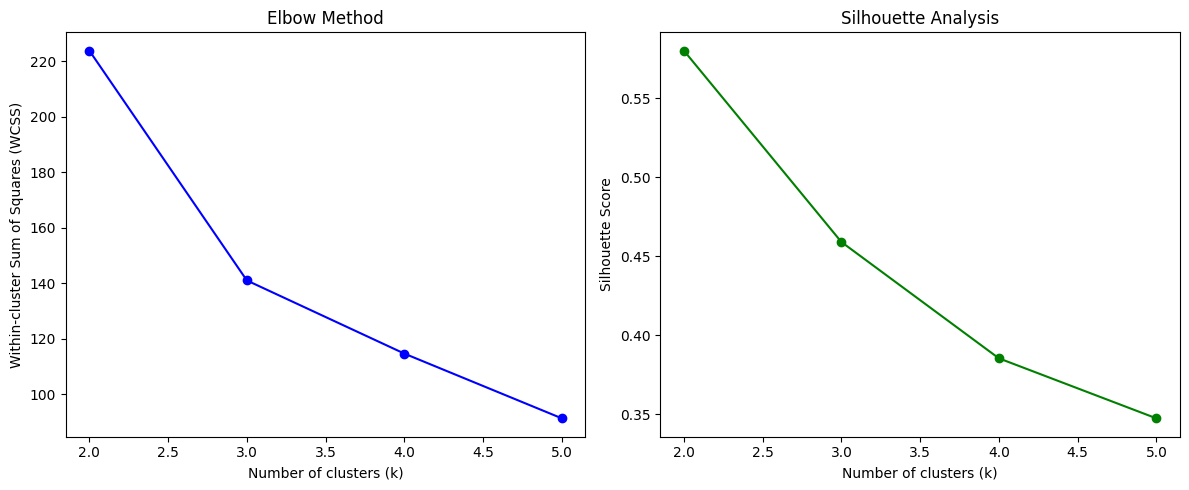


Optimal number of clusters: 3


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


wcss = []
silhouette_scores = []
k_range = range(2,6)

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42,n_init = 10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_scaled,kmeans.labels_))
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(k_range,wcss,'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores,'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()


optimal_k = k_range[np.argmax(silhouette_scores) + 1]  # +1 because we started from k=2
print(f"\nOptimal number of clusters: {optimal_k}")

In [8]:
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal Number of Clusters : {optimal_k}")

Optimal Number of Clusters : 2


In [9]:
for k,score in zip(k_range,silhouette_scores):
    print(f"k = {k} : Silhouette Score = {score:.4f}")

k = 2 : Silhouette Score = 0.5802
k = 3 : Silhouette Score = 0.4590
k = 4 : Silhouette Score = 0.3853
k = 5 : Silhouette Score = 0.3473


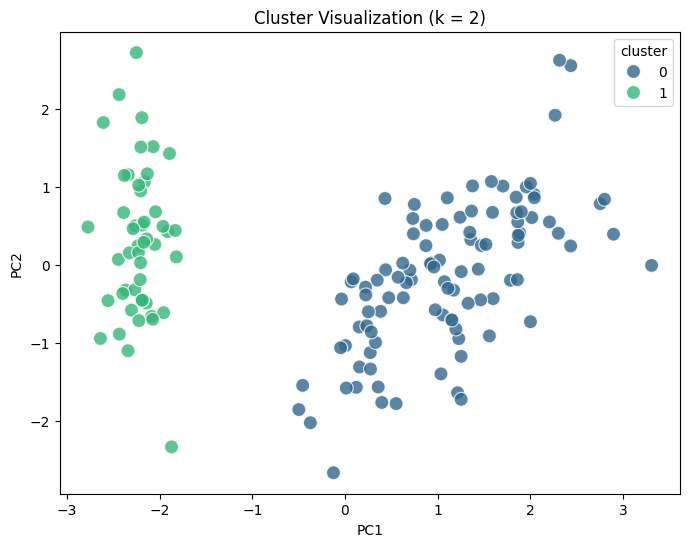

In [11]:
from sklearn.decomposition import PCA


final_kmeans = KMeans(n_clusters = optimal_k,random_state = 42,n_init = 10)
clusters = final_kmeans.fit_predict(X_scaled)

X_clustered = X.copy()
X_clustered['cluster'] = clusters

pca = PCA(n_components = 2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data = principal_components,columns=['PC1','PC2'])
pca_df['cluster'] = clusters

plt.figure(figsize=(8,6))
sns.scatterplot(x = 'PC1', y = 'PC2' , hue = 'cluster',data = pca_df,palette = 'viridis',s = 100,alpha = 0.8)
plt.title(f'Cluster Visualization (k = {optimal_k})')
plt.show()

In [12]:
print('Cluster Characteristics')
print(X_clustered.groupby('cluster').mean())

Cluster Characteristics
         sepal_length  sepal_width  petal_length  petal_width
cluster                                                      
0               6.262        2.872         4.906        1.676
1               5.006        3.418         1.464        0.244


In [13]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Assuming you've already fit KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
labels = kmeans.labels_

# Calculate metrics
silhouette = silhouette_score(X_scaled, labels)
dbi = davies_bouldin_score(X_scaled, labels)
chi = calinski_harabasz_score(X_scaled, labels)

print(f"""
Clustering Quality Metrics:
- Silhouette Score: {silhouette:.3f} (Range: [-1, 1], higher is better)
- Davies-Bouldin Index: {dbi:.3f} (Lower is better)
- Calinski-Harabasz Index: {chi:.3f} (Higher is better)
""")


Clustering Quality Metrics:
- Silhouette Score: 0.479 (Range: [-1, 1], higher is better)
- Davies-Bouldin Index: 0.787 (Lower is better)
- Calinski-Harabasz Index: 156.143 (Higher is better)

